In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import analyze_cells_energy as ace
import re
import utils
import itertools
import seaborn as sns
import utils_PLS as upls

In [2]:
# load query file where we added volumes for each area
volumes = ace.clean_volumes_database()

In [3]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'WILD_with_father'
batch='WILD_with_father2500'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
dict_results_across_mice = np.load('dict_results/newvolumes/dict_results_across_mice_WILD_with_father2500.npy', 
                                   allow_pickle=True).item()

In [4]:
dict_results_across_mice = upls.reformat_dict_acronym(dict_results=dict_results_across_mice, volumes=volumes)

In [5]:
# remove unclean data
dict_results_across_mice.pop('W8Fam')

,area,n_cells,energy,density,relative_density,acronym
0,Frontal pole cerebral cortex,743,2.103171e+06,1361.994644,3.138133,FRP
1,Primary motor area,3250,8.268266e+05,548.930948,1.264776,MOp
2,Secondary motor area,3647,9.629560e+05,533.342677,1.228860,MOs
3,Primary somatosensory area,10027,1.299019e+06,801.136048,1.845875,SSp
4,Supplemental somatosensory area,2965,1.045813e+06,628.371420,1.447813,SSs
...,...,...,...,...,...,...
194,Interfascicular nucleus raphe,89,1.567883e+06,877.162363,2.021045,IF
195,Interpeduncular nucleus,95,4.557648e+05,246.900211,0.568876,IPN
196,Rostral linear nucleus raphe,4,8.893147e+04,59.337093,0.136717,RL
197,Central linear nucleus raphe,39,9.138680e+05,410.155287,0.945027,CLI


# Format data for task PLS

In [6]:
data_ncells = upls.format_data_pls(dict_results=dict_results_across_mice, 
                                   batch=batch, table='n_cells')
data_energy = upls.format_data_pls(dict_results=dict_results_across_mice, 
                                   batch=batch, table='energy')
data_density = upls.format_data_pls(dict_results=dict_results_across_mice, 
                                    batch=batch, table='density')
data_relative_density = upls.format_data_pls(dict_results=dict_results_across_mice, 
                                             batch=batch, table='relative_density')
data_ncells.dropna(inplace=True, axis=1)
data_energy.dropna(inplace=True, axis=1)
data_density.dropna(inplace=True, axis=1)
data_relative_density.dropna(inplace=True, axis=1)
data_ncells.to_csv('./results_pls/'+batch+'_n_cells.csv')
data_energy.to_csv('./results_pls/'+batch+'_energy.csv')
data_density.to_csv('./results_pls/'+batch+'_density.csv')
data_relative_density.to_csv('./results_pls/'+batch+'_relative_density.csv')

# Format data for hierarchy plotting

In [7]:
df_levels = upls.create_df_levels(volumes)

# Apply task PLS

In [8]:
%%bash
python area_pls.py -i results_pls/WILD_with_father2500_n_cells.csv -o './results_pls/WILD_with_father2500_ncells'

In [9]:
%%bash
python area_pls.py -i results_pls/WILD_with_father2500_energy.csv -o './results_pls/WILD_with_father2500_energy'

In [10]:
%%bash
python area_pls.py -i results_pls/WILD_with_father2500_density.csv -o './results_pls/WILD_with_father2500_density'

In [11]:
%%bash
python area_pls.py -i results_pls/WILD_with_father2500_relative_density.csv -o './results_pls/WILD_with_father2500_relative_density'

# PLS ncells

In [12]:
contrasts = pd.read_csv('./results_pls/WILD_with_father_contrasts.csv')
saliences = pd.read_csv('./results_pls/WILD_with_father_saliences.csv')
contrasts = contrasts.rename(columns={"group_Control": "Control", "group_Fam": "Fam", "group_Unfam":"Unfam"})

(<Figure size 936x504 with 3 Axes>,
 array([<AxesSubplot:title={'center':'First salience'}, ylabel='value'>,
        <AxesSubplot:title={'center':'Second salience'}, ylabel='value'>,
        <AxesSubplot:title={'center':'Third salience'}, xlabel='Area', ylabel='value'>],
       dtype=object))

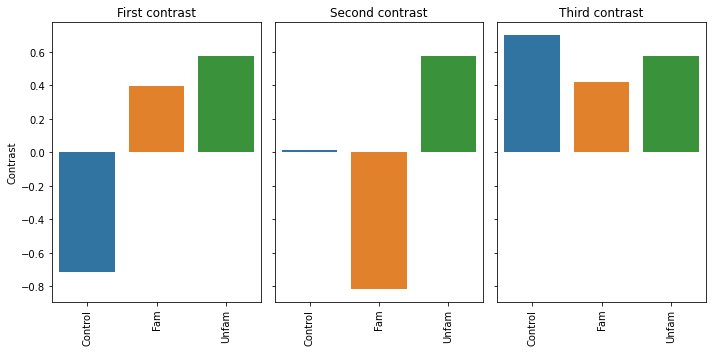

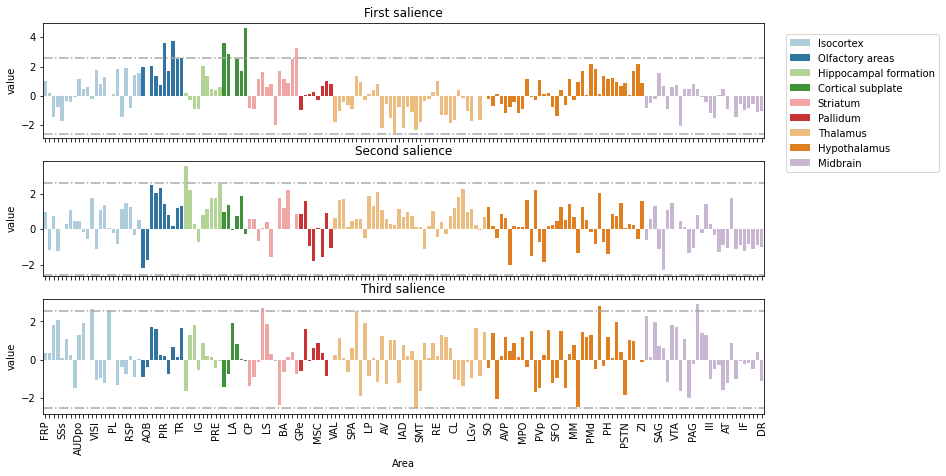

In [13]:
upls.plot_panel_contrasts(batch=batch, variable='ncells')
upls.plot_panel_saliences(batch=batch, variable='ncells', df_levels=df_levels)

# PLS energy

(<Figure size 936x504 with 3 Axes>,
 array([<AxesSubplot:title={'center':'First salience'}, ylabel='value'>,
        <AxesSubplot:title={'center':'Second salience'}, ylabel='value'>,
        <AxesSubplot:title={'center':'Third salience'}, xlabel='Area', ylabel='value'>],
       dtype=object))

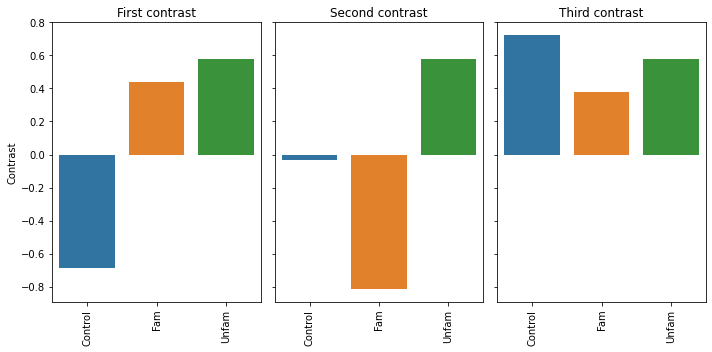

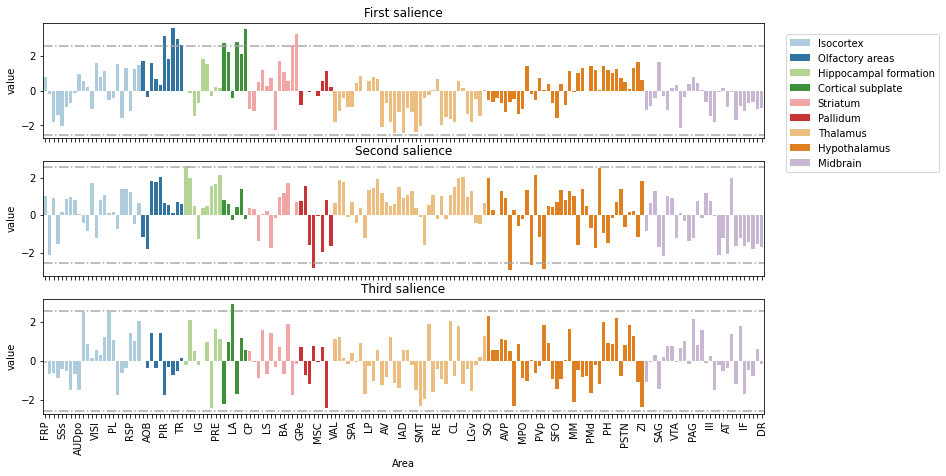

In [14]:
upls.plot_panel_contrasts(batch=batch, variable='energy')
upls.plot_panel_saliences(batch=batch, variable='energy', df_levels=df_levels)

# PLS density

(<Figure size 936x504 with 3 Axes>,
 array([<AxesSubplot:title={'center':'First salience'}, ylabel='value'>,
        <AxesSubplot:title={'center':'Second salience'}, ylabel='value'>,
        <AxesSubplot:title={'center':'Third salience'}, xlabel='Area', ylabel='value'>],
       dtype=object))

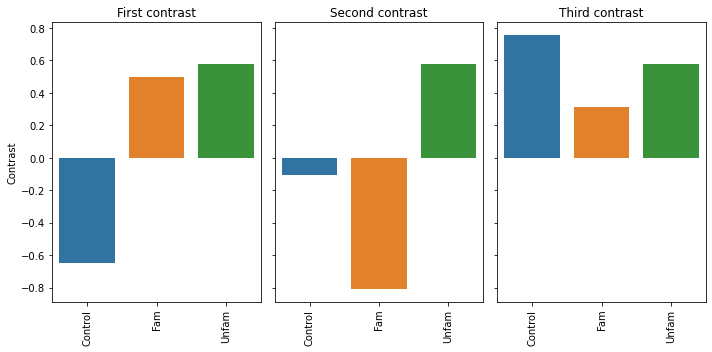

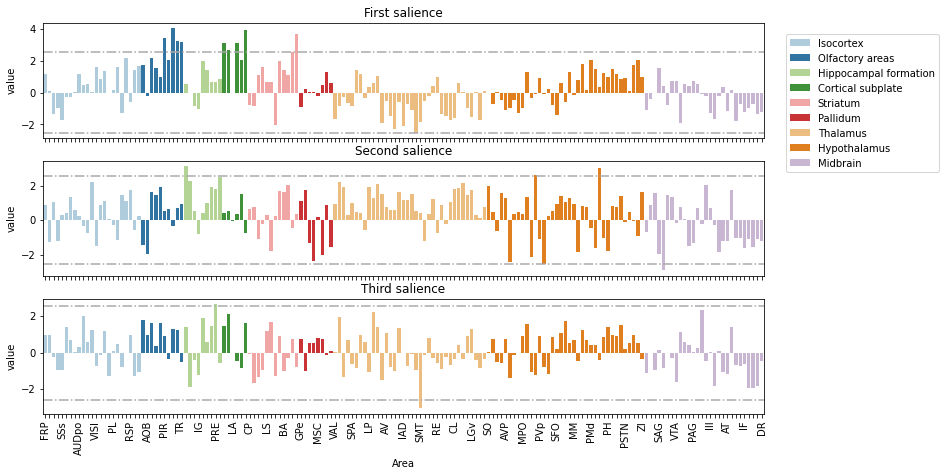

In [15]:
upls.plot_panel_contrasts(batch=batch, variable='density')
upls.plot_panel_saliences(batch=batch, variable='density', df_levels=df_levels)

# PLS relative density

(<Figure size 936x504 with 3 Axes>,
 array([<AxesSubplot:title={'center':'First salience'}, ylabel='value'>,
        <AxesSubplot:title={'center':'Second salience'}, ylabel='value'>,
        <AxesSubplot:title={'center':'Third salience'}, xlabel='Area', ylabel='value'>],
       dtype=object))

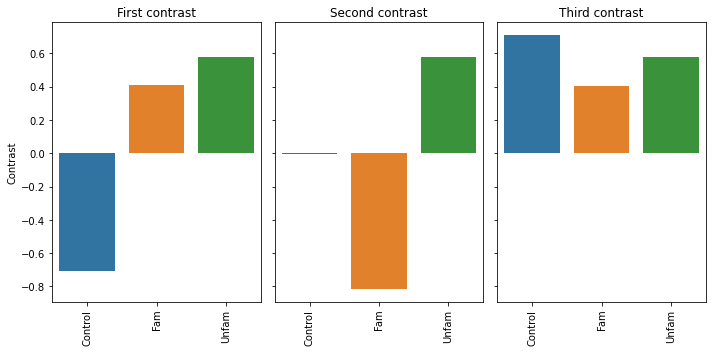

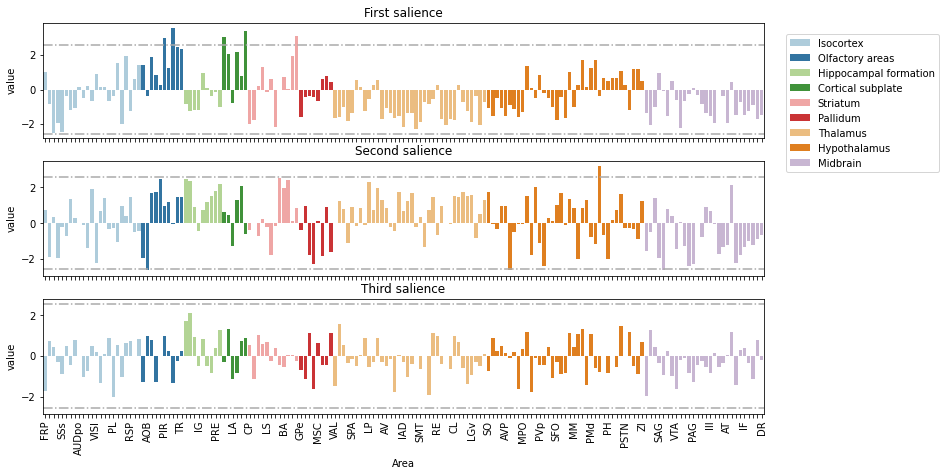

In [16]:
upls.plot_panel_contrasts(batch=batch, variable='relative_density')
upls.plot_panel_saliences(batch=batch, variable='relative_density', df_levels=df_levels)

# Identify areas with significant area contribution

In [17]:
pls_sig_areas = upls.identify_pls_sig_areas(saliences=saliences, 
                                       threshold=2.57, 
                                       volumes=volumes)
np.save('results_pls/pls_sig_areas_WILD_with_father.npy', pls_sig_areas)

In [18]:
pls_sig_areas = np.load('results_pls/pls_sig_areas_WILD_with_father.npy', allow_pickle=True)
pls_sig_areas

array(["Ammon's horn", 'Anteromedial visual area', 'Claustrum',
       'Cortical amygdalar area', 'Endopiriform nucleus',
       'Medial amygdalar nucleus', 'Olfactory tubercle',
       'Paraventricular hypothalamic nucleus descending division',
       'Piriform area', 'Posterior amygdalar nucleus',
       'Postpiriform transition area', 'Pretectal region'], dtype='<U56')

In [19]:
overlap = {'ncells':[], 'energy':[], 'density':[], 'relative_density':[]}
for variable in overlap.keys():
    overlap[variable] = set(upls.identify_pls_sig_areas(saliences=pd.read_csv(
        './results_pls/'+ batch +'_'+ variable +'_saliences.csv'), 
                                           threshold=2.57, 
                                           volumes=volumes))
[len(overlap[key]) for key in overlap.keys()]

[13, 15, 16, 9]

In [20]:
overlap['relative_density']

{'Accessory olfactory bulb',
 'Anteroventral periventricular nucleus',
 'Claustrum',
 'Cortical amygdalar area',
 'Medial amygdalar nucleus',
 'Parabigeminal nucleus',
 'Paraventricular hypothalamic nucleus descending division',
 'Piriform area',
 'Posterior amygdalar nucleus'}

In [21]:
# union between areas significant in all analyses
all_areas = overlap['ncells'].union(overlap['energy']).union(overlap['density']).union(overlap['relative_density'])
# intersection between areas significant in all analyses
intersection = overlap['ncells'].intersection(overlap['energy']).intersection(
    overlap['density']).intersection(overlap['relative_density'])
# filtering
intersection, len(intersection)

({'Claustrum',
  'Cortical amygdalar area',
  'Medial amygdalar nucleus',
  'Piriform area',
  'Posterior amygdalar nucleus'},
 5)

In [22]:
overlap['relative_density']

{'Accessory olfactory bulb',
 'Anteroventral periventricular nucleus',
 'Claustrum',
 'Cortical amygdalar area',
 'Medial amygdalar nucleus',
 'Parabigeminal nucleus',
 'Paraventricular hypothalamic nucleus descending division',
 'Piriform area',
 'Posterior amygdalar nucleus'}

In [23]:
subjects = list(dict_results_across_mice.keys())
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects)
df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')
df_ttest_ncells = ace.test_across_groups([df_control_cell_count,df_fam_cell_count,df_unfam_cell_count])
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])
set(df_ttest_ncells[df_ttest_ncells['pval_Control_vs_Fam']<0.05]['area'].values).union(
set(df_ttest_ncells[df_ttest_ncells['pval_Control_vs_Unfam']<0.05]['area'].values)).union(
set(df_ttest_ncells[df_ttest_ncells['pval_Fam_vs_Unfam']<0.05]['area'].values))

{'Agranular insular area',
 "Ammon's horn",
 'Anterior olfactory nucleus',
 'Basolateral amygdalar nucleus',
 'Claustrum',
 'Cortical amygdalar area',
 'Intercalated amygdalar nucleus',
 'Lateral visual area',
 'Medial amygdalar nucleus',
 'Nucleus sagulum',
 'Parabigeminal nucleus',
 'Piriform area',
 'Piriform-amygdalar area',
 'Posterior amygdalar nucleus',
 'Postpiriform transition area',
 'Septofimbrial nucleus',
 'Substantia nigra compact part',
 'Ventral premammillary nucleus'}

In [24]:
overlap['relative_density'].intersection(set(df_ttest_ncells[df_ttest_ncells['pval_Control_vs_Fam']<0.05]['area'].values).union(
set(df_ttest_ncells[df_ttest_ncells['pval_Control_vs_Unfam']<0.05]['area'].values)).union(
set(df_ttest_ncells[df_ttest_ncells['pval_Fam_vs_Unfam']<0.05]['area'].values)))

{'Claustrum',
 'Cortical amygdalar area',
 'Medial amygdalar nucleus',
 'Parabigeminal nucleus',
 'Piriform area',
 'Posterior amygdalar nucleus'}

In [25]:
pls_sig_areas = upls.identify_pls_sig_areas(saliences=saliences, 
                                       threshold=2.57, 
                                       volumes=volumes)
np.save('results_pls/pls_sig_areas__fatherWILD_with.npy', pls_sig_areas)